In [41]:
"""The `mixed_naive_bayes` module implements Categorical and Gaussian
Naive Bayes algorithms. These are supervised learning methods based on
applying Bayes' theorem with strong (naive) feature independence assumptions.

The API's design is similar to scikit-learn's.

Look at the example in `mixed_naive_bayes.mixed_naive_bayes.MixedNB`.
"""

import warnings
import numpy as np

_ALPHA_MIN = 1e-10


class MixedNB:
    """Naive Bayes classifier for Categorical and Gaussian models.

    Note: When using categorical_features, MixedNB expects that
    for each feature, all possible classes are captured in the
    trining data X in the `mixed_naive_bayes.mixed_naive_bayes.MixedNB.fit` method.
    This is to ensure numerical stability.

    Parameters
    ----------
    categorical_features : array-like shape (num_categorical_classes,) or
    'all' (default=None)
        Columns which have categorical feature_distributions
    max_categories : array-like, shape (num_categorical_classes,) (default=None)
        The maximum number of categories that can be found for each
        categorical feature. If none specified, they will be generated
        automatically.
    alpha : non-negative float, optional (default=0)
        Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
        This is for features with categorical distribution.
    priors : array-like, size (num_classes,), optional (default=None)
        Prior probabilities of the classes. If specified, the priors are not
        adjusted according to the data.
    var_smoothing : float, optional (default=1e-9)
        Portion of the largest variance of all features that is added to
        variances for calculation stability.

    Attributes
    ----------
    priors : array, shape (num_classes,)
        probability of each class.
    epsilon : float
        absolute additive value to variances
    num_samples : int
        number of training samples
    categorical_features : int
        number of classes (number of layes of y)
    gaussian_features : array, shape (num_classes,)
        the distribution for every feature and class
    categorical_posteriors : array
        the distribution of the categorical features
    theta : array
        the mean of the gaussian features
    sigma : array
        the variance of the gaussian features

    References
    ----------
    https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes

    Example
    -------
    >>> from mixed_naive_bayes import MixedNB
    >>> X = [[0, 0, 180, 75],
             [1, 1, 165, 61],
             [2, 1, 166, 60],
             [1, 1, 173, 68],
             [0, 2, 178, 71]]
    >>> y = [0, 0, 1, 1, 0]
    >>> clf = MixedNB(categorical_features=[0,1])
    >>> clf.fit(X,y)
    >>> clf.predict(X)
    """

    def __init__(self, categorical_features=None, max_categories=None,
                 alpha=0.5, priors=None, var_smoothing=1e-9):
        self.alpha = alpha
        self.var_smoothing = var_smoothing
        self.num_features = 0
        self.epsilon = 1e-9
        self._is_fitted = False
        self.max_categories = max_categories
        self.categorical_features = categorical_features
        self.initial_priors = priors

        self.gaussian_features = []
        self.priors = self.initial_priors
        self.theta = []
        self.sigma = []
        self.categorical_posteriors = []

    def __repr__(self):
        return str(f"{self.__class__.__name__}(alpha={self.alpha}, " +
                   f"var_smoothing={self.var_smoothing})")

    def fit(self, X, y):
        """Fit Mixed Naive Bayes according to X, y

        This method also prepares a `self.models` object. Note that the reason
        why some variables are cast to list() is to make the models object
        JSON serializable.

        Parameters
        ----------
        X : array-like, shape (num_samples, n_features)
            Training vectors, where num_samples is the number of samples
            and n_features is the number of features.
        y : array-like, shape (num_samples,)
            Target values.

        Returns
        -------
        self : object
        """
        if self._is_fitted:
            self.gaussian_features = []
            self.priors = self.initial_priors
            self.theta = []
            self.sigma = []
            self.categorical_posteriors = []

        # Validate inputs
        self.alpha = _validate_inits(self.alpha)
        X, y = _validate_training_data(
            X, y, self.categorical_features, self.max_categories)

        # From https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/naive_bayes.py#L344
        # If the ratio of data variance between dimensions is too small, it
        # will cause numerical errors. To address this, we artificially
        # boost the variance by epsilon, a small fraction of the standard
        # deviation of the largest dimension.
        self.epsilon = self.var_smoothing * np.var(X, ddof=1, axis=0).max()

        # Get whatever that is needed
        uniques = np.unique(y)
        num_classes = uniques.size
        (num_samples, self.num_features) = X.shape

        # Correct the inputs
        if self.priors is None:
            self.priors = np.bincount(y)/num_samples
        else:
            self.priors = np.asarray(self.priors)
            if len(self.priors) != num_classes:
                raise ValueError(
                    'Number of priors must match number of classes.')
            if not np.isclose(self.priors.sum(), 1.0):
                raise ValueError("The sum of priors should be 1.")
            if (self.priors < 0).any():
                raise ValueError('Priors must be non-negative.')

        if self.categorical_features is None:
            self.categorical_features = []
        elif self.categorical_features == 'all':
            self.categorical_features = np.arange(0, self.num_features)

        # Get the index columns of the discrete data and continuous data
        self.categorical_features = np.array(
            self.categorical_features).astype(int)
        self.gaussian_features = np.delete(
            np.arange(self.num_features), self.categorical_features)

        # How many categories are there in each categorical_feature
        # Add 1 due to zero-indexing
        if self.max_categories is None:
            self.max_categories = np.max(
                X[:, self.categorical_features], axis=0) + 1
            self.max_categories = self.max_categories.astype(int)
        else:
            self.max_categories = np.array(self.max_categories).astype(int)

        # Prepare empty arrays
        if self.gaussian_features.size != 0:
            self.theta = np.zeros((num_classes, len(self.gaussian_features)))
            self.sigma = np.zeros((num_classes, len(self.gaussian_features)))
        if self.categorical_features.size != 0:
            self.categorical_posteriors = [
                np.zeros((num_classes, num_categories))
                for num_categories in self.max_categories]

        # TODO optimise below!
        for y_i in uniques:

            if self.gaussian_features.size != 0:
                x = X[y == y_i, :][:, self.gaussian_features]
                self.theta[y_i, :] = np.mean(x, axis=0)
                # note: it's really sigma squared
                self.sigma[y_i, :] = np.var(x, axis=0)

            if self.categorical_features.size != 0:
                for i, categorical_feature in enumerate(self.categorical_features):
                    dist = np.bincount(X[y == y_i, :][:, categorical_feature].astype(int),
                                       minlength=self.max_categories[i]) + self.alpha
                    self.categorical_posteriors[i][y_i, :] = dist/np.sum(dist)

        self._is_fitted = True

        return self

    def predict_proba(self, X_test, verbose=False):
        """
        Return probability estimates for the test vector X_test.

        Parameters
        ----------
        X_test : array-like, shape = [num_samples, num_features]

        Returns
        -------
        C : array-like, shape = [num_samples, num_classes]
            Returns the probability of the samples for each class in
            the model. The columns correspond to the classes in sorted
            order, as they appear in the attribute `classes_`.
        """
        if not self._is_fitted:
            raise NotFittedError
        _validate_test_data(X_test, self.num_features)

        X_test = np.array(X_test)

        if self.gaussian_features.size != 0:
            # TODO optimisation: Below is a copy. Can consider masking
            x_gaussian = X_test[:, self.gaussian_features]
            mu = self.theta[:, np.newaxis]
            s = self.sigma[:, np.newaxis] + self.epsilon

            # For every y_class and feature,
            # take values of x's from the samples
            # to get its likelihood
            # (num_classes, num_samples, num_features)
            something = 1./np.sqrt(2.*np.pi*s) * \
                np.exp(-((x_gaussian-mu)**2.)/(2.*s))

            # For every y_class and sample,
            # multiply all the features
            # (num_samples, num_classes)
            t = np.prod(something, axis=2)[:, :, np.newaxis]
            t = np.squeeze(t.T)

        if self.categorical_features.size != 0:

            # Cast tensor to int
            X = X_test[:, self.categorical_features].astype(int)

            # A list of length=num_features.
            # Each item in the list contains the distributions for the y_classes
            # Shape of each item is (num_classes,1,num_samples)
            probas = [categorical_posterior[:, X[:, i][:, np.newaxis]]
                      for i, categorical_posterior
                      in enumerate(self.categorical_posteriors)]

            r = np.concatenate([probas], axis=0)
            r = np.squeeze(r, axis=-1)
            r = np.moveaxis(r, [0, 1, 2], [2, 0, 1])

            # (num_samples, num_classes)
            p = np.prod(r, axis=2).T

        if self.gaussian_features.size != 0 and self.categorical_features.size != 0:
            finals = t * p * self.priors
        elif self.gaussian_features.size != 0:
            finals = t * self.priors
        elif self.categorical_features.size != 0:
            finals = p * self.priors

        normalised = finals/finals.sum(axis=1, keepdims=True)

        return normalised

    def predict(self, X, verbose=False):
        """
        Perform classification on an array of test vectors X.

        Parameters
        ----------
        X : array-like, shape = [num_samples, n_features]

        Returns
        -------
        C : array, shape = [num_samples]
            Predicted target values for X
        """
        probs = self.predict_proba(X, verbose)
        return np.argmax(probs, axis=1)

    def get_params(self, deep=False):
        """Get parameters for this model.

        Returns
        -------
        params : mapping of string to any
            Parameter names mapped to their values.
        """
        return {
            'categorical_features': self.categorical_features,
            'max_categories': self.max_categories,
            'alpha': self.alpha,
            'priors': self.priors,
            'var_smoothing': self.var_smoothing
        }

    def score(self, X, y):
        """Returns the mean accuracy on the given test data and labels.

        Parameters
        ----------
        X : array-like, shape = (num_samples, n_features)
            Test samples.
        y : array-like, shape = (num_samples)
            True labels for X.

        Returns
        -------
        score : float
            Mean accuracy of self.predict(X) wrt. y.
        """
        y_true = np.array(y)
        y_predicted = np.array(self.predict(X))
        bool_comparison = y_true == y_predicted

        return np.sum(bool_comparison) / bool_comparison.size


class NotFittedError(Exception):
    """
    Exception class for cases when the predict API is called before
    model is fitted.
    """

    def __str__(self):
        return "This MixedNB instance is not fitted yet. Call 'fit' \
            with appropriate arguments before using this method."


def _validate_test_data(X, num_features):
    X = np.array(X)

    if X.ndim != 2:
        raise ValueError("Bad input shape of X_test. " +
                         f"Expected an array of dim 2 but got dim {X.ndim} instead.")

    if X.shape[1] != num_features:
        raise ValueError("Bad input shape of X_test. " +
                         f"Expected (,{num_features}) but got (,{X.shape[1]}) instead")


def _validate_inits(alpha):

    if not isinstance(alpha, (int, float)):
        raise TypeError(
            'Expected smoothing parameter alpha to be int or float.')

    if alpha < 0:
        raise ValueError('Expected smoothing parameter alpha > 0. '
                         f'Got {alpha}.')

    if alpha < _ALPHA_MIN:
        warnings.warn('alpha too small will result in numeric errors, '
                      f'setting alpha = {_ALPHA_MIN}')
        alpha = _ALPHA_MIN

    return alpha


def _validate_training_data(X_raw, y_raw, categorical_features, max_categories):
    """Verifying user inputs

    The following will be checked:

    - dimensions
    - number of samples
    - data type (numbers only)
    - data type for categorical distributions (integers only, starting from 0 onwards)
    - number of categories
    """
    ACCEPTABLE_TYPES = ['float64', 'int64', 'float32', 'int32']
    X = np.array(X_raw)
    y = np.array(y_raw)

    if X.ndim != 2:
        raise ValueError("Bad input shape of X. " +
                         f"Expected 2D array, but got {X.ndim}D instead. " +
                         "Reshape your data accordingly.")
    if y.ndim != 1:
        raise ValueError("Bad input shape of y. " +
                         f"Expected 1D array, but got {y.ndim}D instead. " +
                         "Reshape your data accordingly.")

    if X.shape[0] != y.shape[0]:
        raise ValueError(
            "No. of samples in X does not match no. of samples in y")

    if X.dtype not in ACCEPTABLE_TYPES:
        raise TypeError("Expected X to contain only numerics, " +
                         f"but got type {X.dtype} instead. For categorical variables, " +
                         "encode your data using sklearn's LabelEncoder.")

    if y.dtype not in ACCEPTABLE_TYPES:
        raise TypeError("Expected y to contain only numerics, " +
                         f"but got type {y.dtype} instead. For categorical variables, " +
                         "encode your data using sklearn's LabelEncoder.")

    y_classes = np.unique(y)
    if y_classes.size == 1:
        raise ValueError(
            "Found only 1 class in y. There's nothing to classify here!")

    if not np.array_equal(y_classes, np.arange(0, y_classes.size)):
        raise ValueError(f"Expected y to have classes {np.arange(0, y_classes.size)} " +
                         f"but got {y_classes} instead. " +
                         "Encode your data using sklearn's LabelEncoder.")

    if categorical_features is not None:
        if categorical_features == 'all':
            categorical_features = np.arange(0, X.shape[1])
        for feature_no in categorical_features:
            if not np.array_equal(X[:, feature_no], X[:, feature_no].astype(int)):
                warnings.warn(f"Feature no. {feature_no} is continuous data. " +
                              "Casting data to integer.")
            if max_categories is None:
                uniques = np.unique(X[:, feature_no]).astype(int)
                if not np.array_equal(uniques, np.arange(0, np.max(uniques)+1)):
                    raise ValueError(f"Expected feature no. {feature_no} to have " +
                                     f"{np.arange(0,np.max(uniques)+1)} as " +
                                     f"unique values, but got {uniques} instead. " +
                                     "Encode your data using sklearn's LabelEncoder, " +
                                     "or specify the maximum no. of categories this " +
                                     "feature can take.")

    return X, y


def load_example():
    """Load an example dataset"""
    X = [[0, 0, 180.1, 75],
         [1, 1, 165, 61],
         [1, 0, 167, 62],
         [0, 1, 178, 63],
         [1, 1, 174, 69],
         [2, 1, 166, 60],
         [0, 2, 167, 59],
         [2, 2, 165, 60],
         [1, 1, 173, 68],
         [0, 2, 178, 71]]
    y = [0, 0, 1, 0, 0, 0, 1, 1, 0, 0]

    return X, y

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [4]:
!pip install scikit-plot

In [5]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [2]:
# importing dataset
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [6]:
from google.colab import files
uploaded1 = files.upload()

Saving test.csv to test.csv


In [191]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [192]:
import io
df_test = pd.read_csv(io.BytesIO(uploaded1['test.csv']))

In [193]:
df_train


,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.2810,0.6350,142.221,241760,4.0,567.0,141.0,NaN,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.3600,0.0336,75.596,444000,4.0,617.0,155.0,NaN,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.2620,0.4890,116.628,333507,4.0,652.0,162.0,NaN,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.1170,0.3850,140.880,269800,4.0,619.0,155.0,0.469,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.2990,0.6370,143.956,307652,4.0,733.0,183.0,NaN,4.067086,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Outpt,432026,False,0,Autechre,EP7,0.554,0.657,1,-14.232,...,0.1320,0.0335,117.319,432027,NaN,837.0,212.0,NaN,2.367412,idm
14996,Natural Environment Sounds: To Improve Sleep a...,182746,False,44,Natural White Noise Relaxation,Baby Sleep White Noise: Ultimate Album to Help...,0.103,0.860,1,-19.627,...,0.1230,0.0016,92.323,182747,3.0,277.0,92.0,NaN,2.367412,sleep
14997,Psychological Attack,400091,False,43,Droplex,Psychological Attack,0.799,0.535,1,-9.103,...,0.0713,0.0708,126.000,400091,4.0,837.0,209.0,NaN,2.367412,techno
14998,Don't Hate The 808 (feat. Lafa Taylor),197250,False,37,Bassnectar;Lafa Taylor,Noise vs Beauty,0.511,0.970,5,-2.299,...,0.4020,0.2700,160.044,197250,4.0,513.0,130.0,NaN,1.279305,breakbeat


In [91]:
df_test

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Untrue,206826,False,32,Coal Chamber,Chamber Music,0.383,0.9510,0,-3.743,...,0.2610,0.668,110.584,206827,4.0,385.0,96.0,NaN,3.349057,industrial
1,High Roller,329733,False,41,The Crystal Method,Vegas,0.464,0.5790,5,-9.136,...,0.0992,0.140,171.752,329733,4.0,935.0,235.0,NaN,1.279305,breakbeat
2,Na Tum Jano Na Hum (ReVibe),136000,False,40,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.611,0.7780,9,-4.803,...,0.1390,0.285,90.024,136000,4.0,200.0,49.0,NaN,1.343558,indian
3,いじわるなハロー,247040,False,25,Perfume,Cling Cling,0.500,0.9580,0,-1.695,...,0.7320,0.955,130.059,247040,4.0,526.0,132.0,NaN,3.349057,j-idol
4,Hit The Ceiling,208120,False,0,Audio Bullys,Ego War,0.802,0.6840,1,-8.839,...,0.2360,0.637,130.022,208120,4.0,440.0,110.0,NaN,2.367412,breakbeat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Ich war es,80813,False,17,Germaine Franco,Encanto (Deutscher Original Film-Soundtrack),0.217,0.0754,11,-16.629,...,0.1350,0.201,142.026,80813,5.0,175.0,44.0,0.728,0.748116,disney
4996,Giahe Vahshi,261500,False,2,Saeed Dehghan;Pari Eskandari;Beatbynajwa,Oryan,0.467,0.7820,10,-8.136,...,0.0971,0.203,145.059,261500,4.0,621.0,158.0,NaN,0.757389,iranian
4997,Taste - Reaper Remix,258000,False,19,Shiv-R,"Infacted Compilation, Vol. 5",0.524,0.9730,0,-5.214,...,0.1070,0.840,140.029,258000,4.0,594.0,149.0,NaN,3.349057,industrial
4998,Romove,404506,False,19,Skyforger,Senprusija,0.166,0.9750,2,-3.585,...,0.0656,0.233,75.005,404507,4.0,550.0,138.0,NaN,3.700483,black-metal


## Data preparation

In [194]:
#Changing udm to duration_ms and features_duration_ms from ms to min
df_train['duration_ms'] *= 1/6e4
df_test['duration_ms'] *= 1/6e4

In [195]:
#Setting trainset popularity as a %
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting test popularity as a %
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

In [196]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                      4450
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature            2062
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [197]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                     1461
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature            725
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [198]:
#Dealing with mode attribute missing values train set
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0

#Dealing with mode attribute missing values test set
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [199]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]

#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

In [200]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [201]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature              0
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [202]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [203]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats', 'loudness']
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

bayes non gestisce bene attributes highly correlated.

In [204]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values.
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}

## First `genre` map - all genra in a different category

In [149]:
from sklearn.preprocessing import LabelEncoder

In [150]:
#df_train = pd.get_dummies(df_train, columns=['key', 'time_signature'], dtype=int)
#df_test = pd.get_dummies(df_test, columns=['key', 'time_signature'], dtype=int)

In [151]:
# label encoding explicit feature
le = LabelEncoder()
df_train['explicit'] = le.fit_transform(df_train['explicit'])
df_test['explicit'] = le.fit_transform(df_test['explicit'])

In [152]:
df_train

,duration_min,explicit,popularity_percent,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,4.029333,0,0.46,0.690,0.513,5,1.0,0.0975,0.302000,0.536000,0.2810,0.6350,142.221,4.0,1
1,7.400000,0,0.00,0.069,0.196,1,0.0,0.0805,0.283000,0.934000,0.3600,0.0336,75.596,4.0,5
2,5.558433,0,0.03,0.363,0.854,2,1.0,0.0397,0.000089,0.800000,0.2620,0.4890,116.628,4.0,4
3,4.496667,0,0.23,0.523,0.585,5,1.0,0.0765,0.066400,0.001270,0.1170,0.3850,140.880,4.0,3
4,5.127517,0,0.25,0.643,0.687,7,1.0,0.0539,0.000576,0.096900,0.2990,0.6370,143.956,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,7.200433,0,0.00,0.554,0.657,1,1.0,0.0558,0.016000,0.615000,0.1320,0.0335,117.319,4.0,0
14996,3.045767,0,0.44,0.103,0.860,1,1.0,0.0595,0.548000,0.940000,0.1230,0.0016,92.323,3.0,6
14997,6.668183,0,0.43,0.799,0.535,1,0.0,0.0594,0.001830,0.857000,0.0713,0.0708,126.000,4.0,0
14998,3.287500,0,0.37,0.511,0.970,5,1.0,0.0531,0.000337,0.000014,0.4020,0.2700,160.044,4.0,0


In [153]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

In [154]:
df_train.replace({'genre':genre_map}, inplace=True)
df_test.replace({'genre':genre_map}, inplace=True)

In [155]:
y_train = df_train['genre']
y_test = df_test['genre']

In [156]:
X_train = df_train[attributes].values
X_test = df_test[attributes].values

In [157]:
from sklearn.model_selection import train_test_split

In [158]:
'''from mixed_naive_bayes import MixedNB
X = [[0, 0, 180.9, 75.0],
     [1, 1, 165.2, 61.5],
     [2, 1, 166.3, 60.3],
     [1, 1, 173.0, 68.2],
     [0, 2, 178.4, 71.0]]
y = [0, 0, 1, 1, 0]
clf = MixedNB(categorical_features=[0,1])
clf.fit(X,y)
clf.predict(X)'''

'from mixed_naive_bayes import MixedNB\nX = [[0, 0, 180.9, 75.0],\n     [1, 1, 165.2, 61.5],\n     [2, 1, 166.3, 60.3],\n     [1, 1, 173.0, 68.2],\n     [0, 2, 178.4, 71.0]]\ny = [0, 0, 1, 1, 0]\nclf = MixedNB(categorical_features=[0,1])\nclf.fit(X,y)\nclf.predict(X)'

In [159]:
random_state = 0

In [160]:
#clf = GaussianNB()
clf = MixedNB(categorical_features=[1,5,6,13])

In [161]:
#to solve clf.fit value error with column 13
from sklearn.preprocessing import OneHotEncoder

# Assuming X is your feature matrix with the categorical feature at index 12
categorical_feature_index = 13

# Extract the categorical feature
categorical_feature_train = X_train[:, categorical_feature_index].reshape(-1, 1)
categorical_feature_test = X_test[:, categorical_feature_index].reshape(-1, 1)

# Specify the unique values for the categorical feature
unique_values = [0, 1, 3, 4, 5]

# Create and fit the OneHotEncoder
encoder = OneHotEncoder(categories=[unique_values], sparse=False)
encoded_feature_train = encoder.fit_transform(categorical_feature_train)
encoded_feature_test = encoder.fit_transform(categorical_feature_test)

# Replace the original categorical feature with the encoded feature
X_train = np.hstack((X_train[:, :categorical_feature_index], encoded_feature_train, X_train[:, categorical_feature_index + 1:]))
X_test = np.hstack((X_test[:, :categorical_feature_index], encoded_feature_test, X_test[:, categorical_feature_index + 1:]))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [162]:
%%time
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

CPU times: user 26.2 ms, sys: 0 ns, total: 26.2 ms
Wall time: 33 ms


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [163]:
y_pred = clf.predict(X_test)
y_pred

array([2, 0, 2, ..., 0, 4, 0])

In [164]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1500
           1       0.57      0.18      0.27      1500
           2       0.33      0.77      0.47       750
           3       0.33      0.48      0.39       250
           4       0.55      0.60      0.57       250
           5       0.43      0.50      0.46       250
           6       0.52      0.49      0.51       500

    accuracy                           0.48      5000
   macro avg       0.48      0.52      0.47      5000
weighted avg       0.53      0.48      0.46      5000



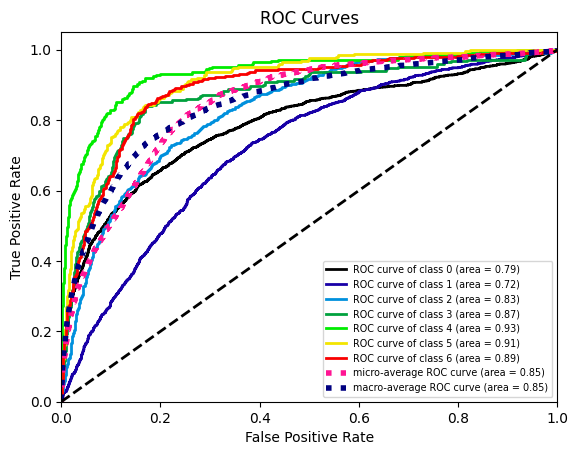

0.8483076585581601


In [165]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='lower right', fontsize='x-small')
#plt.figure(figsize=(20, 17))
plt.show()
print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))


# Decision tree - II map

In [205]:
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":1,"iranian":5,"brazil":2,"chicago-house":0,"forro":2,"idm":0,"indian":1,"study":6,"disney":1,"afrobeat":0,"mandopop":1,"techno":0,"sleep":6,"spanish":2,"j-idol":1,"industrial":0,"happy":1,"bluegrass":3,"black-metal":4,"breakbeat":0}


In [206]:
df_train.replace({'genre':macrogenre_map}, inplace=True)

In [207]:
df_test.replace({'genre':macrogenre_map}, inplace=True)

In [208]:
df_train['genre'].unique()

array([1, 5, 4, 3, 0, 2, 6])

In [209]:
y_train = df_train['genre']
y_test = df_test['genre']

In [210]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

In [211]:
#clf = GaussianNB()
clf = MixedNB(categorical_features=[1,5,6,13])

In [212]:
%%time
clf.fit(X_train, y_train)

CPU times: user 23.1 ms, sys: 0 ns, total: 23.1 ms
Wall time: 23 ms


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [224]:
y_pred = clf.predict(X_test)
y_pred

array([2, 0, 2, ..., 0, 4, 0])

In [225]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1500
           1       0.57      0.18      0.27      1500
           2       0.33      0.77      0.47       750
           3       0.33      0.48      0.39       250
           4       0.55      0.60      0.57       250
           5       0.43      0.50      0.46       250
           6       0.52      0.49      0.51       500

    accuracy                           0.48      5000
   macro avg       0.48      0.52      0.47      5000
weighted avg       0.53      0.48      0.46      5000



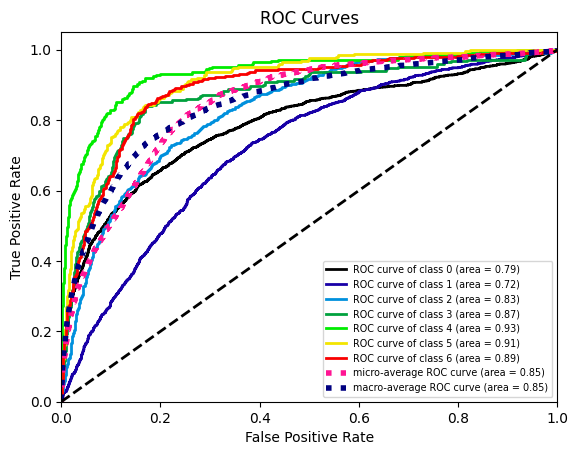

0.8483076585581601


In [226]:
plot_roc(y_test, clf.predict_proba(X_test))
plt.legend(loc='lower right', fontsize='x-small')
#plt.figure(figsize=(20, 17))
plt.show()
print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", average="macro"))